In [52]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subject_data
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import shap
from imblearn.over_sampling import SMOTE


In [36]:
def filter_valid_days_nights(group, gap_minutes=15, gap_threshold=2, night_reading_threshold=69, day_reading_threshold=213):
    # Function to identify the day corresponding to a given night (6 AM previous date to 11:59 PM)
    def get_corresponding_day(date_time):
        if date_time.hour < 6:  # If before 6 AM, it belongs to the previous day
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()

    group = group.copy()

    # Identify the corresponding day for each measurement
    group['corresponding_day'] = group['time'].apply(get_corresponding_day)

    # Calculate time differences within each day
    group['time_diff'] = group.groupby('corresponding_day')['time'].diff()

    # Function to check if there are fewer than gap_threshold gaps and enough readings
    def has_fewer_gaps_and_enough_readings(subgroup, night=False):
        if night:
            return ((subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold) and (len(subgroup) > night_reading_threshold)
        return ((subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold) and (len(subgroup) > day_reading_threshold)

    # Identify days with fewer than gap_threshold gaps and more than day_reading_threshold readings
    days_with_fewer_gaps = group[(group['time'].dt.hour >= 6)].groupby('corresponding_day').apply(has_fewer_gaps_and_enough_readings)

    print(days_with_fewer_gaps)

    # Filter for night time measurements between 12 AM and 6 AM
    nights_with_fewer_gaps = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)].groupby('corresponding_day').apply(has_fewer_gaps_and_enough_readings, night=True)

    print(nights_with_fewer_gaps[0])
        
    # Count valid nights where the corresponding day also meets criteria
    valid_days_nights = (nights_with_fewer_gaps & days_with_fewer_gaps).reindex(nights_with_fewer_gaps.index, fill_value=False)
    
    # Filter the group to include only the rows with valid days and nights
    filtered_group = group[group['corresponding_day'].isin(valid_days_nights.index)].copy()

    # Days with >40 change in bgl within any 20 minute time window should be filtered out
    filtered_group.drop(columns=['time_diff'], inplace=True)

    
    
    return filtered_group

blah = filter_valid_days_nights(train_data)

/var/folders/6j/zxy_nmpx04gg6ssx89r9gl5h0000gn/T/ipykernel_2880/756127333.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(days_with_fewer_gaps[0])


False


/var/folders/6j/zxy_nmpx04gg6ssx89r9gl5h0000gn/T/ipykernel_2880/756127333.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nights_with_fewer_gaps[0])


True


In [38]:
average_values_per_day = train_data.groupby('corresponding_day').().mean()
print(average_values_per_day)


21303.2343470483


In [37]:
print(len(blah))
print(len(train_data))

11907793
11908508


In [50]:
!pip3 install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [4]:
cgm = subject_data.df_CGM
cgm['time'] = pd.to_datetime(cgm['time'])

In [5]:
# Get the unique IDs from the 'id' column of the 'cgm' DataFrame
unique_ids = cgm['id'].unique()

# Split the unique IDs into training and test sets
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create the training and test DataFrames based on the split IDs
train_data = cgm[cgm['id'].isin(train_ids)]
test_data = cgm[cgm['id'].isin(test_ids)]


In [6]:
def filter_valid_days_nights(group, gap_minutes=20, gap_threshold=8, night_reading_threshold=55, day_reading_threshold=150):
    # Function to identify the day corresponding to a given night (6 AM previous date to 11:59 PM)
    def get_corresponding_day(date_time):
        if date_time.hour < 6:  # If before 6 AM, it belongs to the previous day
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()

    # Identify the corresponding day for each measurement
    group['corresponding_day'] = group['time'].apply(get_corresponding_day)

    # Calculate time differences within each day
    group['time_diff'] = group.groupby('corresponding_day')['time'].diff()

    # Function to check if there are fewer than gap_threshold gaps and enough readings
    def has_fewer_gaps_and_enough_readings(subgroup):
        return ((subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold) and (len(subgroup) > day_reading_threshold)

    # Identify days with fewer than gap_threshold gaps and more than day_reading_threshold readings
    days_with_fewer_gaps = group.groupby('corresponding_day').apply(has_fewer_gaps_and_enough_readings)

    # Filter for night time measurements between 12 AM and 6 AM
    nights_group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]

    # Check if each night has more than night_reading_threshold readings
    nights_with_enough_readings = nights_group.groupby('corresponding_day').apply(lambda x: len(x) > night_reading_threshold)
        
    # Count valid nights where the corresponding day also meets criteria
    valid_days_nights = nights_with_enough_readings & days_with_fewer_gaps.reindex(nights_with_enough_readings.index, fill_value=False)
    
    # Filter the group to include only the rows with valid days and nights
    filtered_group = group[group['corresponding_day'].isin(valid_days_nights.index)]

    filtered_group.drop(columns=['time_diff'], inplace=True)
    
    return filtered_group

# Apply the function to each patient ID
filtered_data = cgm.groupby('id').apply(filter_valid_days_nights)


In [7]:
filtered_data.head(2000470)



id                time    bgl corresponding_day
id                                                         
2  1118188   2 2015-05-22 10:37:40  144.0        2015-05-22
   1118194   2 2015-05-22 10:38:32  154.0        2015-05-22
   1118229   2 2015-05-22 10:41:29  143.0        2015-05-22
   1118288   2 2015-05-22 10:46:29  151.0        2015-05-22
   1118347   2 2015-05-22 10:51:29  149.0        2015-05-22
...         ..                 ...    ...               ...
39 8057962  39 2015-09-16 04:17:35  113.0        2015-09-15
   8058165  39 2015-09-16 04:22:35  113.0        2015-09-15
   8058368  39 2015-09-16 04:27:35  111.0        2015-09-15
   8058571  39 2015-09-16 04:32:35  108.0        2015-09-15
   8058774  39 2015-09-16 04:37:35  104.0        2015-09-15

[2000470 rows x 4 columns]

In [8]:
day = filtered_data[(filtered_data['time'].dt.hour >= 6) & (filtered_data['time'].dt.hour < 24)].rename(columns={'id': 'patient_id'})
night = filtered_data[(filtered_data['time'].dt.hour >= 0) & (filtered_data['time'].dt.hour < 6)].rename(columns={'id': 'patient_id'})

In [7]:
night.head(1500)

patient_id                time    bgl corresponding_day
id                                                                 
2  1143099           2 2015-05-23 00:01:25   82.0        2015-05-22
   1143303           2 2015-05-23 00:06:25   80.0        2015-05-22
   1143507           2 2015-05-23 00:11:25   82.0        2015-05-22
   1143711           2 2015-05-23 00:16:25   83.0        2015-05-22
   1143914           2 2015-05-23 00:21:25   86.0        2015-05-22
...                ...                 ...    ...               ...
   2336223           2 2015-06-12 05:23:57  215.0        2015-06-11
   2336436           2 2015-06-12 05:28:57  212.0        2015-06-11
   2336647           2 2015-06-12 05:33:56  211.0        2015-06-11
   2336855           2 2015-06-12 05:38:56  209.0        2015-06-11
   2337064           2 2015-06-12 05:43:57  201.0        2015-06-11

[1500 rows x 4 columns]

In [9]:
night.reset_index(inplace=True)
night_hypo = night.groupby(['id', 'corresponding_day']).agg({'bgl': lambda x: (x < 70).mean() > 0.04}).rename(columns={'bgl': 'hypo'}).reset_index()


In [10]:
night_hypo.head(1500)

,id,corresponding_day,hypo
0,2,2015-05-22,False
1,2,2015-05-23,False
2,2,2015-05-24,False
3,2,2015-05-25,False
4,2,2015-05-26,False
...,...,...,...
1495,10,2015-07-02,False
1496,10,2015-07-03,True
1497,10,2015-07-04,False
1498,10,2015-07-05,False


In [11]:
day_resampled = day.groupby(['id', 'corresponding_day']).resample('5T', on='time').mean().reset_index(level=[0, 1])
#day_resampled.dropna(inplace=True)


In [12]:
day_resampled.head(1500)

,id,corresponding_day,patient_id,bgl
time,,,,
2015-05-22 10:35:00,2,2015-05-22,2.0,149.0
2015-05-22 10:40:00,2,2015-05-22,2.0,143.0
2015-05-22 10:45:00,2,2015-05-22,2.0,151.0
2015-05-22 10:50:00,2,2015-05-22,2.0,149.0
2015-05-22 10:55:00,2,2015-05-22,2.0,140.0
...,...,...,...,...
2015-05-29 09:10:00,2,2015-05-29,NaN,NaN
2015-05-29 09:15:00,2,2015-05-29,NaN,NaN
2015-05-29 09:20:00,2,2015-05-29,NaN,NaN


In [13]:
grouped_df = day_resampled.groupby(['id', 'corresponding_day']).apply(lambda x: pd.Series({'times': x.index, 'bgl_values': x['bgl'].values}))


In [14]:
grouped_df = grouped_df[grouped_df['bgl_values'].apply(len) == 216]

In [15]:
grouped_df.head(1000)

times  \
id corresponding_day                                                      
2  2015-05-23         DatetimeIndex(['2015-05-23 06:00:00', '2015-05...   
   2015-05-24         DatetimeIndex(['2015-05-24 06:00:00', '2015-05...   
   2015-05-25         DatetimeIndex(['2015-05-25 06:00:00', '2015-05...   
   2015-05-26         DatetimeIndex(['2015-05-26 06:00:00', '2015-05...   
   2015-05-27         DatetimeIndex(['2015-05-27 06:00:00', '2015-05...   
...                                                                 ...   
8  2015-09-05         DatetimeIndex(['2015-09-05 06:00:00', '2015-09...   
   2015-09-06         DatetimeIndex(['2015-09-06 06:00:00', '2015-09...   
   2015-09-07         DatetimeIndex(['2015-09-07 06:00:00', '2015-09...   
   2015-09-08         DatetimeIndex(['2015-09-08 06:00:00', '2015-09...   
   2015-09-09         DatetimeIndex(['2015-09-09 06:00:00', '2015-09...   

                                                             bgl_values  
id corresponding_day                                                     
2  2015-05-23         [129.0, 130.0, 133.0, 136.0, 140.0, 139.0, 140...  
   2015-05-24         [348.0, 344.0, 345.0, 344.0, 340.0, 338.0, 335...  
   2015-05-25         [115.0, 117.0, 116.0, 112.0, 106.0, 110.0, 110...  
   2015-05-26         [162.0, 159.0, 163.0, 169.0, 169.0, 169.0, 167...  
   2015-05-27         [159.0, 160.0, 162.0, 163.0, 164.0, 164.0, 160...  
...                                                                 ...  
8  2015-09-05         [92.0, 92.0, 94.0, 104.0, 104.0, 99.0, 128.0, ...  
   2015-09-06         [115.0, 111.0, 108.0, 104.0, 102.0, 99.0, 89.0...  
   2015-09-07         [154.0, 151.0, 146.0, 141.0, 142.0, 141.0, 135...  
   2015-09-08         [79.0, 77.0, 75.0, 73.0, 71.0, 70.0, 64.0, 59....  
   2015-09-09         [100.0, 101.0, 99.0, 96.0, 97.0, 97.0, 95.0, 9...  

[1000 rows x 2 columns]

In [16]:
cleaned_formatted_data = grouped_df.merge(night_hypo, on=['id', 'corresponding_day'], how='inner')

In [17]:
len(cleaned_formatted_data)

49125

In [18]:
# Get the unique IDs from the 'id' column of the 'cgm' DataFrame
unique_ids = cleaned_formatted_data['id'].unique()

# Split the unique IDs into training and test sets
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create the training and test DataFrames based on the split IDs
train_data = cleaned_formatted_data[cleaned_formatted_data['id'].isin(train_ids)]
test_data = cleaned_formatted_data[cleaned_formatted_data['id'].isin(test_ids)]


In [19]:
test_data.head(1000)

,id,corresponding_day,times,bgl_values,hypo
1964,15,2015-04-23,"DatetimeIndex(['2015-04-23 06:00:00', '2015-04...","[107.0, 111.0, 108.0, 108.0, 108.0, 113.0, 124...",False
1965,15,2015-04-24,"DatetimeIndex(['2015-04-24 06:00:00', '2015-04...","[124.0, 123.0, 124.0, 125.0, 130.0, 132.0, 137...",True
1966,15,2015-04-25,"DatetimeIndex(['2015-04-25 06:00:00', '2015-04...","[107.0, 107.0, 107.0, 107.0, 107.0, 107.0, 107...",True
1967,15,2015-04-26,"DatetimeIndex(['2015-04-26 06:00:00', '2015-04...","[122.0, 115.0, 108.0, 100.0, 91.0, 85.0, 82.0,...",True
1968,15,2015-04-27,"DatetimeIndex(['2015-04-27 06:00:00', '2015-04...","[66.0, 69.0, 80.0, 96.0, 111.0, 125.0, 130.0, ...",False
...,...,...,...,...,...
5665,33,2015-11-26,"DatetimeIndex(['2015-11-26 06:00:00', '2015-11...","[131.0, 131.0, 129.0, 127.0, 127.0, 124.0, 119...",True
5666,33,2015-11-27,"DatetimeIndex(['2015-11-27 06:00:00', '2015-11...","[181.0, 177.0, 174.0, nan, nan, 174.0, 163.0, ...",False
5667,33,2015-11-29,"DatetimeIndex(['2015-11-29 06:00:00', '2015-11...","[122.0, 121.0, 122.0, 122.0, 125.0, 123.0, 121...",False
5668,33,2015-11-30,"DatetimeIndex(['2015-11-30 06:00:00', '2015-11...","[265.0, 268.0, 273.0, 276.0, 270.0, 259.0, 255...",False


In [54]:
from collections import Counter
counter=Counter(train_data['hypo'].to_numpy())

In [55]:
print(counter)

Counter({False: 32782, True: 6489})


In [67]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_test_flattened = np.array([arr.flatten() for arr in test_data['bgl_values']])
X_train_flattened = np.array([arr.flatten() for arr in train_data['bgl_values']])

# Initialize the IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

# Fit the imputer on the training data and transform both training and test data
# Note: It's important to fit the imputer only on the training data to avoid data leakage
imp.fit(X_train_flattened)
X_train_imputed = imp.transform(X_train_flattened)
X_test_imputed = imp.transform(X_test_flattened)


/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [68]:
oversample = SMOTE()
x_test, y_test = X_test_imputed, test_data['hypo'].to_numpy()
x_train, y_train = oversample.fit_resample(X_train_imputed, train_data['hypo'].to_numpy())

In [71]:
print(Counter(y_train))

Counter({False: 32782, True: 32782})


In [75]:
print(len(x_train))


65564


In [21]:
transformed_x_test = np.stack(x_test.apply(lambda x: x))
transformed_x_train = np.stack(x_train.apply(lambda x: x))


In [76]:
bst = XGBClassifier(max_depth=4, learning_rate=1, objective='binary:logistic')
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [87]:
preds = bst.predict(x_test)


In [78]:
explainer = shap.Explainer(bst)

In [88]:
shap_values = explainer(x_test)

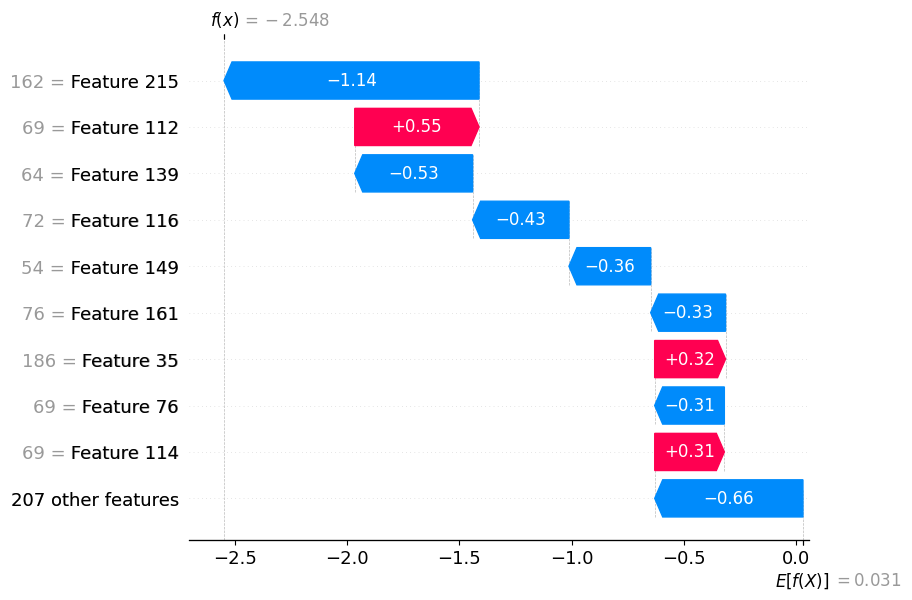

In [89]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

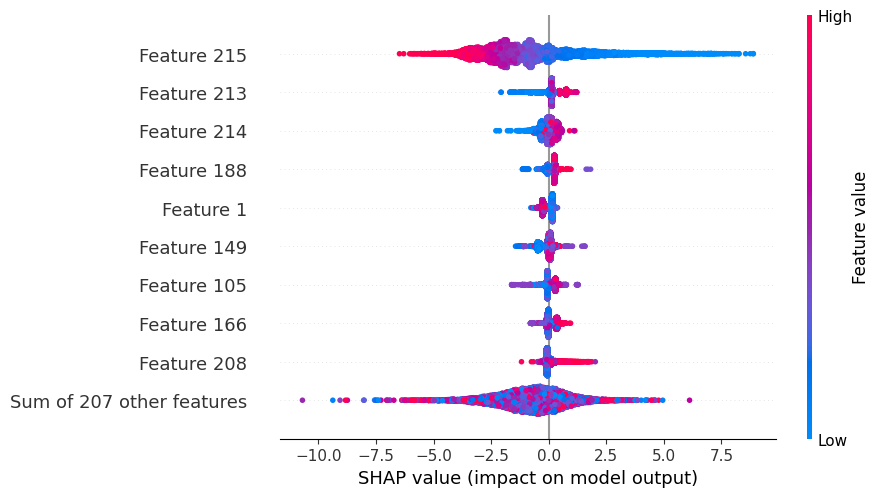

In [90]:
# visualize the first prediction's explanation with a force plot
shap.plots.beeswarm(shap_values)

In [91]:
from sklearn.metrics import accuracy_score, roc_auc_score
#accuracy_score(y_test, preds)
roc_auc_score(y_test, preds)

0.6672200302071392